# Electrical Distribution Network Energy Consumption Forecasting based upon Victorian MRIM Meter Data

In this notebook, the Energy Consumption from CitiPower will be forecasted based on Historical Data Using LSTM. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data = pd.read_csv('citipower.csv')

In [3]:
data.head()

,SETTD,DAILYT
0,2014-04-01,6363749.701
1,2014-04-02,5630825.535
2,2014-04-03,5173891.385
3,2014-04-04,5044050.180
4,2014-04-05,4383318.300


In [4]:
data['SETTD'] = pd.to_datetime(data['SETTD'])

In [5]:
data.set_index('SETTD',inplace = True)
data.head()

,DAILYT
SETTD,
2014-04-01,6363749.701
2014-04-02,5630825.535
2014-04-03,5173891.385
2014-04-04,5044050.180
2014-04-05,4383318.300


Reframing the dataset such that the neural network will forecast the next value based on 2 weeks of historical data.

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
reframed = series_to_supervised(data, 14, 1)


In [8]:
reframed.head()

,var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
SETTD,,,,,,,,,,,,,,,
2014-04-15,6363749.701,5630825.535,5173891.385,5044050.180,4383318.300,4262109.115,5099462.930,5181023.405,5263781.889,5291241.455,5253397.465,4462922.879,4318969.114,5128605.399,5158090.480
2014-04-16,5630825.535,5173891.385,5044050.180,4383318.300,4262109.115,5099462.930,5181023.405,5263781.889,5291241.455,5253397.465,4462922.879,4318969.114,5128605.399,5158090.480,5214111.668
2014-04-17,5173891.385,5044050.180,4383318.300,4262109.115,5099462.930,5181023.405,5263781.889,5291241.455,5253397.465,4462922.879,4318969.114,5128605.399,5158090.480,5214111.668,5042052.798
2014-04-18,5044050.180,4383318.300,4262109.115,5099462.930,5181023.405,5263781.889,5291241.455,5253397.465,4462922.879,4318969.114,5128605.399,5158090.480,5214111.668,5042052.798,4251321.740
2014-04-19,4383318.300,4262109.115,5099462.930,5181023.405,5263781.889,5291241.455,5253397.465,4462922.879,4318969.114,5128605.399,5158090.480,5214111.668,5042052.798,4251321.740,4279159.798


In [9]:
data.head(15)

,DAILYT
SETTD,
2014-04-01,6363749.701
2014-04-02,5630825.535
2014-04-03,5173891.385
2014-04-04,5044050.180
2014-04-05,4383318.300
2014-04-06,4262109.115
2014-04-07,5099462.930
2014-04-08,5181023.405
2014-04-09,5263781.889


# Splitting Train/Test

As usual, I will be forecasting the energy consumption from 1 January 2019 till 30 September 2019.

In [10]:
values = reframed.values

n_test_time = 273
train = values[:-n_test_time, :]
test = values[-n_test_time:, :]

To reduce computational cost, the train and test set are transformed with the MinMaxScaler function.

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [13]:
# split into input and outputs
train_X, train_y = scaled_train[:, :-1], scaled_train[:, -1]
test_X, test_y = scaled_test[:, :-1], scaled_test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(1722, 14, 1) (1722,) (273, 14, 1) (273,)


# Modelling

In [14]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [15]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [16]:
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=80, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

Train on 1722 samples, validate on 273 samples
Epoch 1/100
 - 7s - loss: 0.0944 - val_loss: 0.0312
Epoch 2/100
 - 2s - loss: 0.0249 - val_loss: 0.0312
Epoch 3/100
 - 2s - loss: 0.0227 - val_loss: 0.0302
Epoch 4/100
 - 2s - loss: 0.0225 - val_loss: 0.0300
Epoch 5/100
 - 2s - loss: 0.0216 - val_loss: 0.0299
Epoch 6/100
 - 2s - loss: 0.0218 - val_loss: 0.0298
Epoch 7/100
 - 2s - loss: 0.0214 - val_loss: 0.0296
Epoch 8/100
 - 2s - loss: 0.0210 - val_loss: 0.0293
Epoch 9/100
 - 2s - loss: 0.0210 - val_loss: 0.0290
Epoch 10/100
 - 3s - loss: 0.0207 - val_loss: 0.0287
Epoch 11/100
 - 2s - loss: 0.0205 - val_loss: 0.0284
Epoch 12/100
 - 2s - loss: 0.0204 - val_loss: 0.0281
Epoch 13/100
 - 2s - loss: 0.0201 - val_loss: 0.0278
Epoch 14/100
 - 2s - loss: 0.0203 - val_loss: 0.0276
Epoch 15/100
 - 2s - loss: 0.0201 - val_loss: 0.0273
Epoch 16/100
 - 2s - loss: 0.0198 - val_loss: 0.0270
Epoch 17/100
 - 2s - loss: 0.0197 - val_loss: 0.0267
Epoch 18/100
 - 2s - loss: 0.0195 - val_loss: 0.0265
Epoch 19

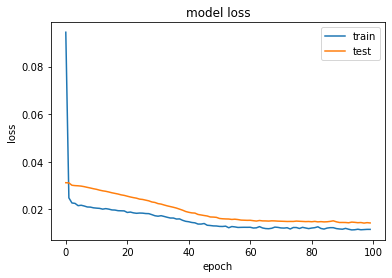

In [17]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [18]:
# make a prediction
yhat = model.predict(test_X)
res_test_X = test_X.reshape((test_X.shape[0], 14))
# invert scaling for forecast
inv_yhat = np.concatenate((res_test_X[:, -14:], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((res_test_X[:, -14:], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

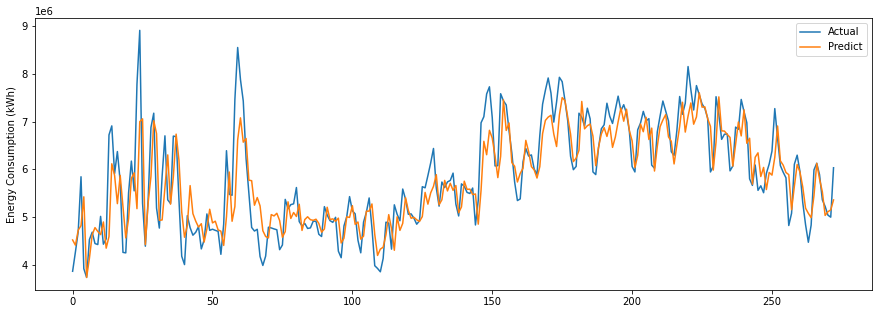

In [19]:
plt.figure(figsize = (15,5))
plt.plot(inv_y, label = 'Actual')
plt.plot(inv_yhat, label = 'Predict')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()

# Performance Metric

In [20]:
from sklearn.metrics import r2_score
#############################################
#         evaluation function by AMMAR      #
#############################################
# Evaluation metrics
# MAPE mean_absolute_percentage_error
def regMAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1.))) * 100


# print_error
def regPrintErr(y_true, y_pred):
    print('R2 Score: {}'.format(r2_score(y_true, y_pred)))
    print('MAPE: {}'.format(regMAPE(y_true, y_pred)))

In [21]:
regPrintErr(inv_y,inv_yhat)

R2 Score: 0.7230214599923221
MAPE: 7.063276732341361


The model evaluations are performed in 'Model Evaluation' notebook.

In [22]:
results = {'Actual': inv_y, 'LSTM': inv_yhat}

In [23]:
results_LSTM = pd.DataFrame(results)

In [24]:
results_LSTM.head()

,Actual,LSTM
0,3858957.991,4.515832e+06
1,4264155.819,4.406280e+06
2,4690920.697,4.721521e+06
3,5841792.852,4.815758e+06
4,3913922.670,5.420984e+06


In [25]:
results_LSTM.to_csv('results_LSTM.csv')